In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib ipympl
plt.rcParams['figure.figsize'] = [12, 4]
mpl.rc('image', cmap='gray')
import matplotlib.animation
writervideo = matplotlib.animation.FFMpegWriter(fps=30)

import numpy as np
import pandas as pd

import pims
import trackpy as tp
tp.quiet()
from PIL import Image, ImageDraw
import cv2

from tqdm import tqdm
import timeit

import random

run_analysis_verb = True
show_verb = False
save_verb = True

# PRE PROCESSING

In [2]:
@pims.pipeline
def crop(image, x1, y1, x2, y2):    
    npImage = np.array(image)
    # Create same size alpha layer with circle
    #alpha = Image.new('L', (920, 960), 0)
    alpha = Image.new('L', (920, 960), 0)

    draw = ImageDraw.Draw(alpha)
    draw.pieslice(((x1, y1), (x2, y2)), 0, 360, fill=255)

    # Convert alpha Image to numpy arrayf
    npAlpha = np.array(alpha)
    npImage = npImage[:, :, 1] * npAlpha
    
    ind = np.where(npImage == 0)
    # npImage[200, 200] color of the border to swap with the black
    npImage[ind] = npImage[200, 200]
    return npImage

In [ ]:
data = crop(pims.open('./data/movie.mp4'), 55, 55, 880, 880)
data_ref = pims.open('./data/movie.mp4')

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(data[0])
ax2.imshow(data_ref[0])
plt.tight_layout()
if save_verb: plt.savefig('./results/pre_processing.png' bbox_inches='tight')
if 1: 
    plt.show()
else:
    plt.close()

# TRACKING 

In [ ]:
# parameters of the tracking
dropSize = 31  
minMass = 2000
sep = 16
nDrops = 50

In [ ]:
# FEATURES LOCATION

nFrames = 100 # total number of frames of video --> len(data)
startFrame = 0
endFrame = startFrame + nFrames

f = tp.batch(data[startFrame:endFrame], dropSize, minmass = minMass, separation = sep, topn = nDrops, engine = 'numba')    
display(f)

In [ ]:
# ANOMALIES DETECTION

num = np.zeros(nFrames)
for i in range(nFrames):
    num[i] = len(f.loc[f['frame'] == i])

idx = np.where(num != nDrops)[0]
print(idx)

if len(idx) != 0:
    delta = np.zeros(len(idx)-1)
    for i in range(len(idx)-1):
        delta[i] = idx[i+1]-idx[i]
    print(delta)

In [ ]:
# FEATURES LINKING
""" f : DataFrame
    The DataFrame must include any number of column(s) for position and a
    column of frame numbers. By default, 'x' and 'y' are expected for
    position, and 'frame' is expected for frame number. See below for
    options to use custom column names.
search_range : float or tuple
    the maximum distance features can move between frames,
    optionally per dimension
pos_columns : list of str, optional
    Default is ['y', 'x'], or ['z', 'y', 'x'] when 'z' is present in f
t_column : str, optional
    Default is 'frame'
memory : integer, optional
    the maximum number of frames during which a feature can vanish
"""

t = tp.link_df(f, 150, memory = 2, link_strategy = 'hybrid', neighbor_strategy = 'KDTree', adaptive_stop = 1)
display(t)

In [ ]:
n = max(t.particle)
print(n)
random.seed(5)
colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(n)]
for i in range(max(t.particle)+1-n):
    colors.append("#00FFFF")
c = []
for p in t.particle:
    c.append(colors[p])
t["color"] = c


In [ ]:
lost_particles = []
for i in range(nFrames-1):
    a = t.loc[t.frame == i].sort_values('particle').particle.values
    b = t.loc[t.frame == i+1].sort_values('particle').particle.values
    ind = np.where(np.in1d(a, b)==False)[0]
    if ind.size > 0:
        lost_particles.append([i, a[ind]])

print("Total problems:", len(lost_particles))
if len(lost_particles) > 0: 
    print(f"First failure occurred at frame {lost_particles[0][0]}")
    f1 = lost_particles[0][0]
    f2 = lost_particles[0][0]+1
    print(t.loc[t.frame == f1].sort_values('particle').particle.values)
    print(t.loc[t.frame == f2].sort_values('particle').particle.values)

In [ ]:
if len(lost_particles)>0: 
    fig, (ax, ax1) = plt.subplots(1, 2)
    df = t.loc[t['frame'] == f1, ["x", "y", "color", "particle"]]
    ax.scatter(df.x, df.y, s=50, ec = "w", facecolor = df.color)
    #ax.scatter(df.loc[df.particle==43].x, df.loc[df.particle==43].y, s=100)
    #ax.scatter(df.loc[df.particle==82].x, df.loc[df.particle==82].y, s=100)
    ax.imshow(data[f1])

    df1 = t.loc[t['frame'] == f2, ["x", "y", "color"]]
    ax1.scatter(df1.x, df1.y, s=50, ec = "w", facecolor = df1.color)
    ax1.imshow(data[f2])

    plt.show()

In [ ]:
t1 = tp.filter_stubs(t, nFrames/2)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

In [ ]:
plt.figure()
tp.plot_traj(t1)
plt.show()

In [ ]:
plt.figure()
plt.title(f"1: {len(t1[t1['particle'] == 0].x)}")
plt.plot(t1[t1['particle'] == 0].x, t1[t1['particle'] == 0].y, linewidth=.1)
plt.plot(t1[t1['particle'] == 1].x, t1[t1['particle'] == 1].y, linewidth=.1)
plt.plot(t1[t1['particle'] == 2].x, t1[t1['particle'] == 2].y, linewidth=.1)
plt.show()

In [ ]:
df = rawTrajs.loc[(rawTrajs.frame == 0) , ["x", "y", "color"]]
fig, ax = plt.subplots(1,1)
ax.scatter(df.x, df.y, facecolors = 'none', edgecolors = df.color, s = 150)
ax.imshow(data[0])
if save_verb: plt.savefig("../results/location_example.png",  bbox_inches='tight')
if show_verb: 
    plt.show()
else:
    plt.close()

fig = plt.figure()
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(frame):
    df = rawTrajs.loc[(rawTrajs.frame == frame) & (rawTrajs.particle == red_particle_idx) , ["x","y","color"]]
    graph.set_offsets(df)
    graph.set_edgecolor(df.color)
    graph2.set_data(data[frame])
    title.set_text('frame = {}'.format(frame))
    return graph

ax = fig.add_subplot(111)
title = ax.set_title('frame = 0')
df = rawTrajs.loc[(rawTrajs.frame == 0) & (rawTrajs.particle == red_particle_idx), ["x","y","color"]]

graph = ax.scatter(df.x, df.y, facecolors = 'none', edgecolors = df.color, s = 150)

graph2 = ax.imshow(data[0])

fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, 100, interval = 5, blit=False)
if 0: ani.save('../results/video/tracking.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
if anim_show_verb:
    plt.show()
else:
    plt.close()


# cose

In [3]:
rawTrajs = pd.read_parquet("./results/parquet/pre_merge_tracking.parquet")#pd.read_parquet("./results/parquet/full_movie_tracking.parquet")
means = rawTrajs.groupby("frame").mean()
display(means)

,y,x,mass,size,ecc,signal,raw_mass,ep,particle
frame,,,,,,,,,
0,480.995205,490.537081,7279.778189,10.445559,0.026929,14.667949,74732.26,0.001097,24.5
1,480.043702,490.189282,7269.428047,10.439215,0.027027,14.107693,74734.76,0.000828,24.5
2,480.082003,490.450112,7270.873325,10.458197,0.026399,14.205718,74641.02,0.000434,24.5
3,479.776959,490.519005,7304.318561,10.442812,0.027302,14.104485,74715.96,0.000411,24.5
4,479.592461,490.214969,7313.451025,10.439867,0.023419,14.306231,74700.36,0.000810,24.5
...,...,...,...,...,...,...,...,...,...
31995,448.074744,463.096351,10230.957134,10.324817,0.052383,20.098632,84238.06,0.002511,24.5
31996,448.073665,463.282275,10232.427926,10.321958,0.054236,20.280792,84305.94,0.001473,24.5
31997,448.144237,463.496549,10208.024328,10.294183,0.053857,20.229405,84123.62,0.001922,24.5


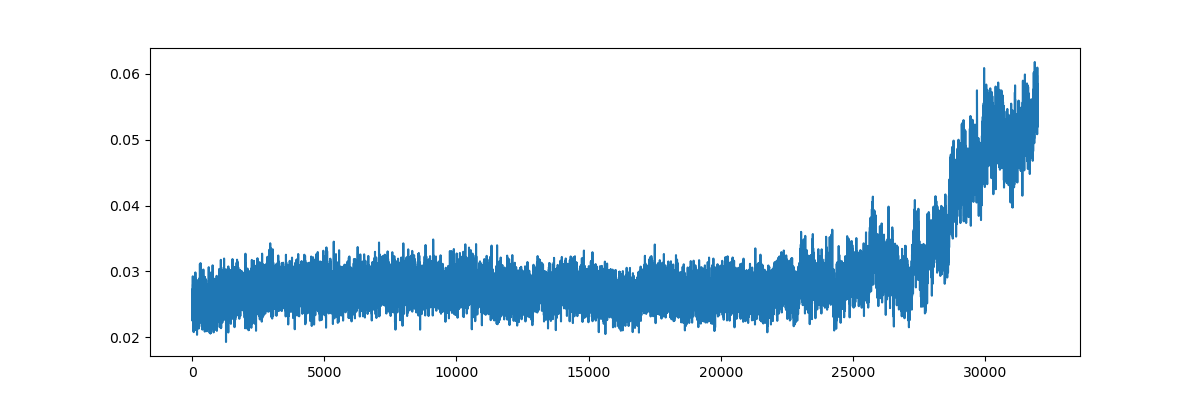

In [6]:
fig, ax = plt.subplots(1, 1)
ax.plot(means["ecc"])
plt.show()

# DIMENSION 

In [2]:
@pims.pipeline
def crop(image, x1, y1, x2, y2):    
    npImage = np.array(image)
    # Create same size alpha layer with circle
    #alpha = Image.new('L', (920, 960), 0)
    alpha = Image.new('L', (920, 960), 0)

    draw = ImageDraw.Draw(alpha)
    draw.pieslice(((x1, y1), (x2, y2)), 0, 360, fill=255)

    # Convert alpha Image to numpy arrayf
    npAlpha = np.array(alpha)
    npImage = npImage[:, :, 1] * npAlpha
    
    ind = np.where(npImage == 0)
    # npImage[200, 200] color of the border to swap with the black
    npImage[ind] = npImage[200, 200]
    return npImage

In [3]:
data = crop(pims.open('./data/movie.mp4'), 55, 55, 880, 880)
data_preload = data[:100]

deprecated pixel format used, make sure you did set range correctly


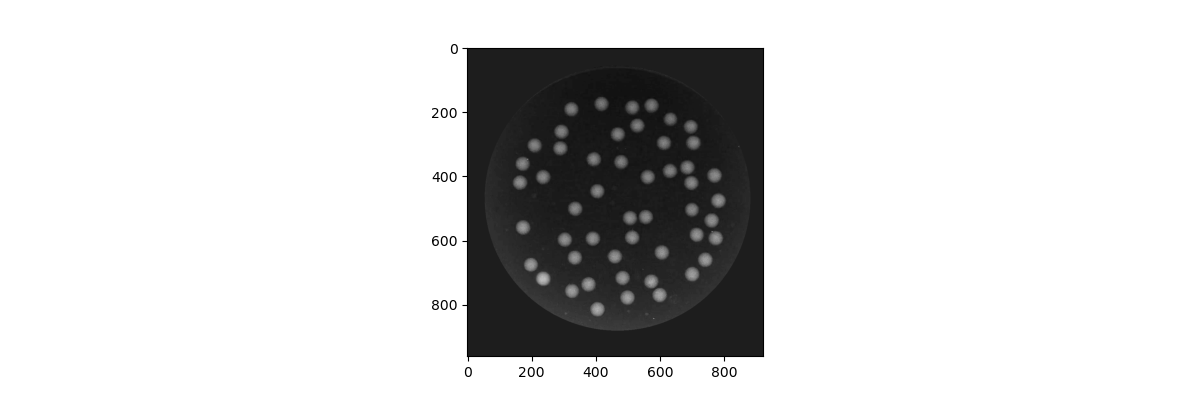

In [4]:
fig, ax = plt.subplots(1, 1)
ax.imshow(data_preload[0])
plt.show()

In [ ]:
# this gives better result
circles = np.empty((100, 50, 3))
for i in tqdm(range(100)):
    temp = cv2.HoughCircles(data_preload[i], cv2.HOUGH_GRADIENT_ALT, 1.5, minDist = 20, param1=100, param2=0.4, minRadius=12, maxRadius=25)
    if temp is None:
        print("temp is none")
        break
    elif temp.shape == (1, 50, 3):
        circles[i] = temp[0]
    else:
        err_ind = i
        print(f"Error found at farme {err_ind}: {temp.shape}")
        break

In [ ]:
np.mean(circles[:err_ind], axis = 2)

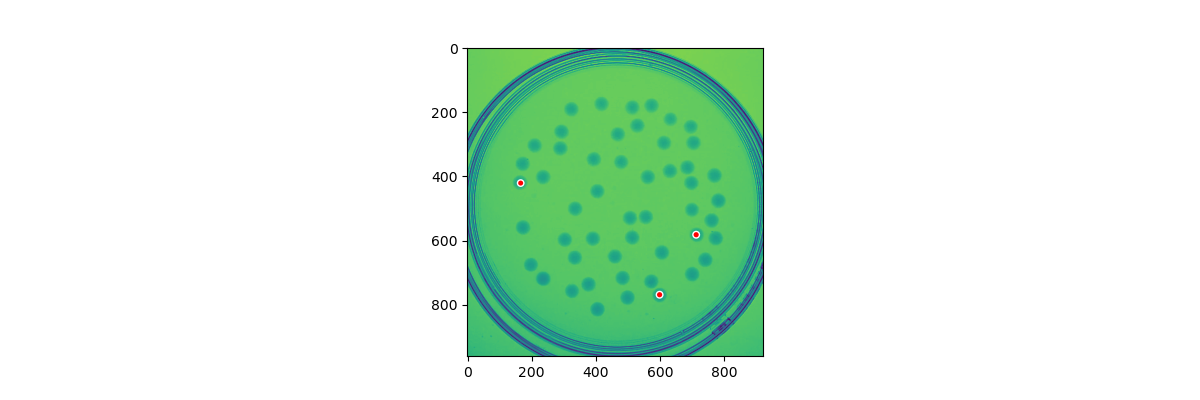

In [49]:
fig, ax = plt.subplots(1, 1)
ax.imshow(data[0])
ax.scatter(temp[0, :, 0], temp[0, :, 1], s = temp[0, :, 2], ec = "w", facecolor = "r")
plt.show()

# estimate error in the tracking

I note that between frames 18300 and 18900 a droplet 40 seems stable and isolated.\
Then applying a rectangular mask around it I compute the "benchmark" position of the droplet using Canny Edge Detection and Hough Transform.\
Finally I confront the tracking result with the benchmark and different window sizes of smoothing.

In [2]:
# apply mask to perform edge detection only on the benchmark particle
@pims.pipeline
def crop2(image, x1, y1, x2, y2):   
    npImage = np.array(image)
    alpha = Image.new('L', (920, 960), 0)
    draw = ImageDraw.Draw(alpha)
    draw.rectangle([(x1, y1), (x2, y2)], fill = 255)
    npAlpha = np.array(alpha)
    npImage = npImage[:, :, 1] * npAlpha
    return npImage

In [3]:
startFrame = 18300
endFrame = 18900
framesArray = np.arange(startFrame, endFrame, 1) 

rawTrajs = pd.read_parquet("./results/parquet/pre_merge_tracking.parquet")
benchmark_particle_id = 40
print("Benchmark particle:", benchmark_particle_id)
rawTraj = rawTrajs.loc[(rawTrajs.frame.between(startFrame, endFrame-1)) & (rawTrajs.particle == benchmark_particle_id)]
if 1: ref = list(pims.open('./data/movie.mp4')[startFrame:endFrame])

Benchmark particle: 40


deprecated pixel format used, make sure you did set range correctly
deprecated pixel format used, make sure you did set range correctly


In [4]:
# apply mask to perform edge detection only on the benchmark particle
y1 = rawTraj.iloc[0].y - 50
x1 = rawTraj.iloc[0].x - 50
y2 = rawTraj.iloc[0].y + 110
x2 = rawTraj.iloc[0].x + 120
if 1: ref_masked = list(crop2(pims.open('./data/movie.mp4'), x1, y1, x2, y2)[startFrame:endFrame])

deprecated pixel format used, make sure you did set range correctly
 (repeated 18649 more times)
deprecated pixel format used, make sure you did set range correctly
deprecated pixel format used, make sure you did set range correctly


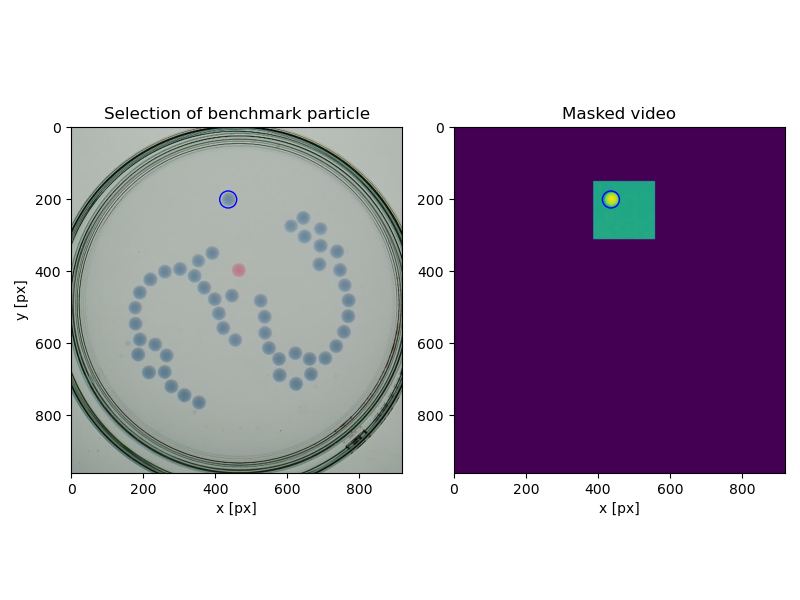

In [8]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize = (8, 6))
ax.imshow(ref[0])
ax.scatter(rawTraj.iloc[0].x, rawTraj.iloc[0].y, s=150, facecolors='none', edgecolors='b')
ax.set(title = "Selection of benchmark particle", xlabel = "x [px]", ylabel = "y [px]")
ax1.imshow(ref_masked[0])
ax1.scatter(rawTraj.iloc[0].x, rawTraj.iloc[0].y, s=150, facecolors='none', edgecolors='b')
ax1.set(title = "Masked video", xlabel = "x [px]")
plt.tight_layout()
plt.savefig("./results/error_estimation/masked_frame.png", bbox_inches='tight')
plt.show()

/Users/matteoscandola/miniconda3/envs/pyenv3/lib/python3.10/site-packages/matplotlib/animation.py:887: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


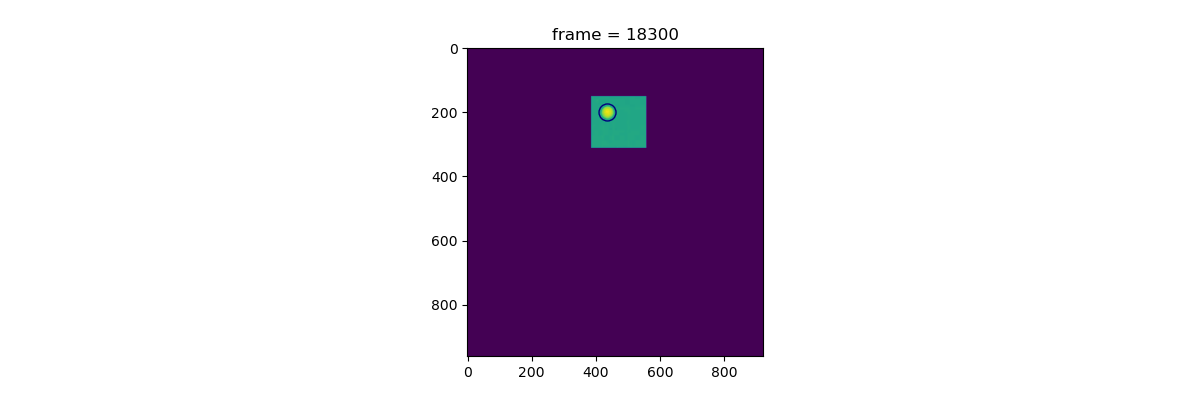

In [9]:
# needed to check that only particle 40 is selected by the mask
fig = plt.figure()
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(frame):
    df = rawTraj.loc[rawTraj.frame == startFrame + frame, ["x","y", "color"]]
    graph.set_offsets(df)
    graph2.set_data(ref_masked[frame])
    title.set_text('frame = {}'.format(startFrame + frame))
    return graph

ax = fig.add_subplot(111)
title = ax.set_title(f'frame = {startFrame}')
df = rawTraj.loc[rawTraj.frame == startFrame, ["x","y", "color"]]

graph = ax.scatter(df.x, df.y, facecolors = 'none', edgecolors= df.color, s = 150)

graph2 = ax.imshow(ref_masked[0])

fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, endFrame-startFrame, interval = 2, blit=False)
plt.show()

In [10]:
circles = []
problems = 0

for i in tqdm(range(0, len(ref_masked))):
    img = ref_masked[i]
    """
                    -- this works fine !!!!! --
    # Apply Canny Edge Detection to find edges in the image
    edges = cv2.Canny(img, 30, 30)
    # Apply the Hough Transform to find circles in the image 
    temp = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, 1, minDist=20, param1=50, param2=30, minRadius=0, maxRadius=0)
    if temp is not None:
        circles.append(temp[0][0])
   """
    
    # this gives better results
    temp = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT_ALT, 1.5, minDist=1, param1=300, param2=0.6, minRadius=10, maxRadius=21)
    if temp is not None:
        circles.append(temp[0][0])
        
    else:
        break
        problems += 1
print("Number of problems:", problems)

100%|██████████| 600/600 [00:05<00:00, 116.35it/s]

Number of problems: 0


In [11]:
x = np.zeros(len(circles))
y = np.zeros(len(circles))
d = np.zeros(len(circles))

for i in range(len(circles)):
    x[i] = circles[i][0]
    y[i] = circles[i][1]
    d[i] = circles[i][2]
    
benchmark_traj = pd.DataFrame({"x": x, "y": y, "d": d})

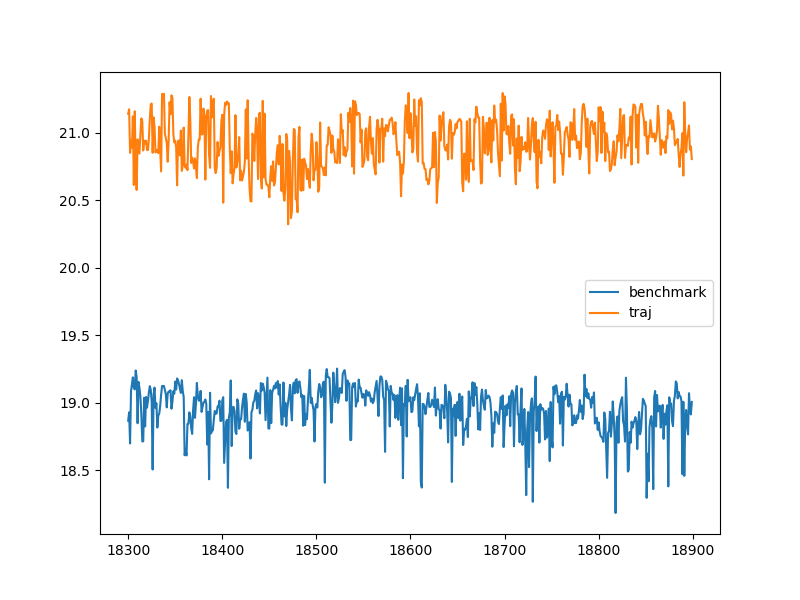

In [13]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
ax.plot(np.arange(startFrame, endFrame, 1), benchmark_traj.d, label = "benchmark")
ax.plot(np.arange(startFrame, endFrame, 1), 2*rawTraj["size"], label = "traj")
ax.legend()
plt.show()

deprecated pixel format used, make sure you did set range correctly
 (repeated 18649 more times)


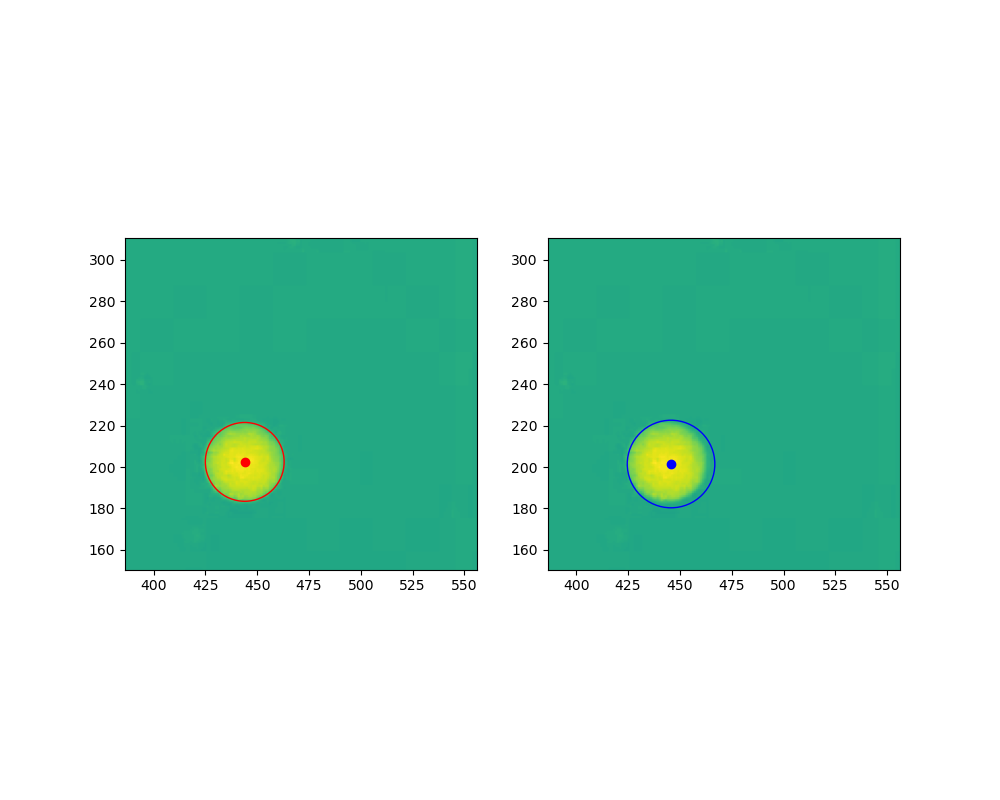

In [15]:
c1 = plt.Circle(( x[100] , y[100] ), d[100], fill = False, color = "red")
c2 = plt.Circle((rawTraj.x.values[100], rawTraj.y.values[100]), 2*rawTraj["size"].values[100], fill = False, color="blue")

fig, (ax, ax1) = plt.subplots(1, 2, figsize = (10, 8))
ax.imshow(ref_masked[100])
ax.add_artist(c1)
ax.scatter(x[100], y[100], color = "red")
ax.set(xlim = (x1, x2), ylim = (y1, y2))
ax1.imshow(ref_masked[100])
ax1.add_artist(c2)
ax1.scatter(rawTraj.x.values[100], rawTraj.y.values[100], color = "blue")
ax1.set(xlim = (x1, x2), ylim = (y1, y2))
plt.show()

## POSITION ERROR

In [16]:
tracking_pos = np.sqrt(rawTraj.x**2 + rawTraj.y**2)

benchmark_pos = np.sqrt(x**2 + y**2)
mse_raw = ((benchmark_pos - tracking_pos)**2).mean()
print("MSE with raw trajectory:", mse_raw)

MSE with raw trajectory: 4.191993973958964


In [17]:
from scipy.signal import savgol_filter
def get_smooth_trajs(trajs, nDrops, windLen, orderofPoly):
    # Trajectory Smoothing: using a Savgol Filter in order to drop the noise due to the tracking procedure
    ret = trajs.copy()
    for i in range(nDrops):
        ret.loc[ret.particle == i, "x"] = savgol_filter(trajs.loc[trajs.particle == i].x.values, windLen, orderofPoly)
        ret.loc[ret.particle == i, "y"] = savgol_filter(trajs.loc[trajs.particle == i].y.values, windLen, orderofPoly)    
    return ret

In [18]:
windLen = 30
smoothTrajs = get_smooth_trajs(rawTrajs, 50, windLen, 2)
smoothTraj = smoothTrajs.loc[(smoothTrajs.frame.between(startFrame, endFrame-1)) & (smoothTrajs.particle == benchmark_particle_id)]
tracking_smooth_pos = np.sqrt(smoothTraj.x**2 + smoothTraj.y**2)
mse = ((benchmark_pos - tracking_smooth_pos)**2).mean()
print(f"MSE smoothing window {windLen}:", mse)

MSE smoothing window 30: 1.6294871210727186


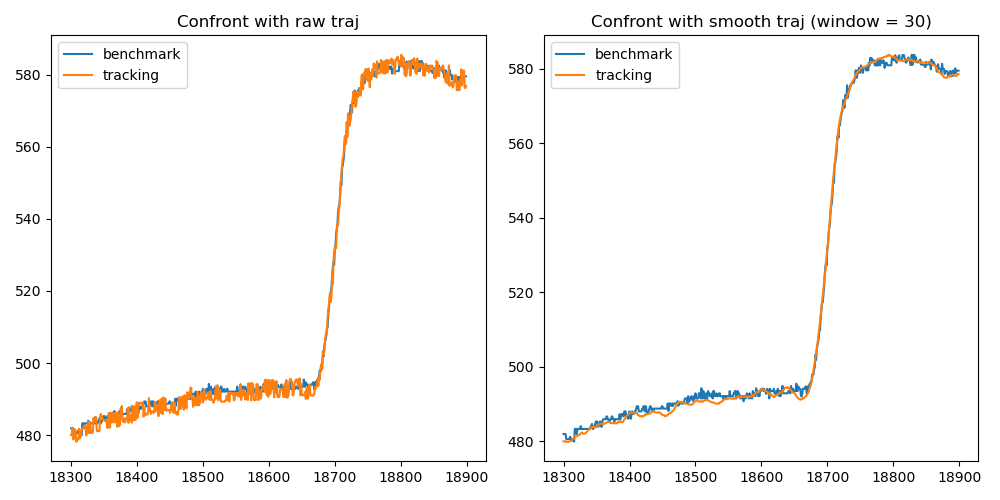

In [19]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize = (10, 5))
ax.plot(framesArray, benchmark_pos, label = "benchmark")
ax.plot(framesArray, tracking_pos, label = "tracking")
ax.set_title("Confront with raw traj")
ax1.plot(framesArray, benchmark_pos, label = "benchmark")
ax1.plot(framesArray, tracking_smooth_pos, label = "tracking")
ax1.set_title(f"Confront with smooth traj (window = {windLen})")
ax.legend()
ax1.legend()
plt.tight_layout()
plt.savefig("./results/error_estimation/benchmark_confront_wind30.png", bbox_inches='tight')
plt.show()

### MSE ANALYSIS OF THE SMOOTHING WINDOW

In [20]:
windLenList = np.arange(3, 100, 1)
mse = np.zeros(len(windLenList))

for k in tqdm(range(len(windLenList))):
    smoothTrajs = get_smooth_trajs(rawTrajs, 50, windLenList[k], 2)
    smoothTraj = smoothTrajs.loc[(smoothTrajs.frame.between(startFrame, endFrame-1)) & (smoothTrajs.particle == benchmark_particle_id)]
    tracking_smooth_pos = np.sqrt(smoothTraj.x**2 + smoothTraj.y**2)
    mse[k] = ((benchmark_pos - tracking_smooth_pos)**2).mean()

100%|██████████| 97/97 [03:00<00:00,  1.86s/it]


In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
ax.hlines(mse_raw, windLenList[0], windLenList[-1], 'r', label = "raw")
ax.plot(windLenList, mse, label = "smooth")
ax.set_title("MSE vs smoothing window")
ax.set_xlabel("Smoothing window")
ax.set_ylabel("MSE")
ax.legend(loc='center right')
plt.savefig("./results/error_estimation/mse_vs_window.png", bbox_inches='tight')
plt.show()

# TRACKING WITHOUT TRACKPY

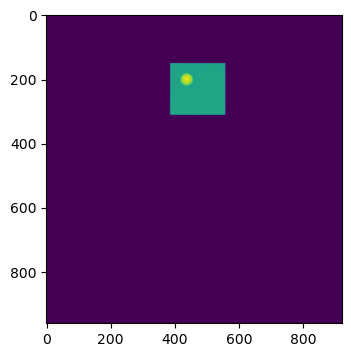

In [85]:
fig, ax = plt.subplots(1,1)
ax.imshow(ref_masked[2])
plt.show()

In [81]:
from scipy.optimize import linear_sum_assignment

# Initialize a list to store the circle data
circles_list = []

for i in tqdm(range(0, len(ref))):
    img = ref_masked[i]
    
    # Detect the circles in the frame
    circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT_ALT, 1.5, minDist=1, param1=300, param2=0.6, minRadius=10, maxRadius=21)
    
    # If circles were detected, add them to the list
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        circles_list.append(circles)

100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:03<00:00, 159.87it/s]


In [82]:
circles_list

[array([[438, 201,  19]]),
 array([[438, 201,  19]]),
 array([[438, 201,  19],
        [430, 206,  14]]),
 array([[438, 201,  19],
        [429, 196,  15]]),
 array([[436, 201,  19]]),
 array([[436, 201,  19],
        [441, 207,  16],
        [432, 207,  15],
        [446, 201,  15]]),
 array([[436, 201,  19],
        [446, 201,  15],
        [441, 208,  15],
        [444, 196,  14]]),
 array([[436, 201,  19],
        [444, 204,  16]]),
 array([[436, 201,  19],
        [434, 194,  15]]),
 array([[436, 201,  19],
        [436, 195,  16]]),
 array([[436, 202,  19],
        [436, 195,  16]]),
 array([[436, 201,  19],
        [432, 201,  16],
        [436, 195,  16]]),
 array([[436, 201,  19],
        [436, 195,  16]]),
 array([[436, 201,  19]]),
 array([[436, 201,  19],
        [446, 201,  15],
        [432, 206,  15]]),
 array([[436, 200,  19]]),
 array([[436, 200,  19],
        [434, 194,  15]]),
 array([[440, 201,  19],
        [434, 208,  14],
        [430, 206,  14]]),
 array([[440, 

In [ ]:

# Initialize a dictionary to store the circle data
circles_dict = {}
next_id = 0

# Loop through the frames
for frame_idx, circles in enumerate(circles_list):
    # Initialize a cost matrix for the circles in this frame and the previous frame
    num_circles = len(circles)
    if frame_idx == 0:
        prev_circles = []
        cost_matrix = np.zeros((num_circles, 1))
    else:
        prev_circles = circles_list[frame_idx-1]
        num_prev_circles = len(prev_circles)
        cost_matrix = np.zeros((num_circles, num_prev_circles))
        for i, (x1, y1, r1) in enumerate(circles):
            for j, (x2, y2, r2) in enumerate(prev_circles):
                dist = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
                cost_matrix[i, j] = dist
    
    # Use the Hungarian algorithm to find the optimal assignment of circles
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Add the circles to the dictionary
    for i, j in zip(row_ind, col_ind):
        if frame_idx == 0:
            circles_dict[next_id] = [(circles[i][0], circles[i][1], circles[i][2])]
            next_id += 1
       


# MERGING ANALYSIS

In [ ]:
preMerge = data[32268]
merge = data[32269]
postMerge = data[32270]

# feature location with minMass, have some problems but the spurious effect are solved
f = tp.locate(preMerge, dropSize, minmass = minMass, separation = sep, topn = nDrops, engine = 'numba')

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(f['mass'], bins = 20)
ax1.set(xlabel='mass', ylabel='count')
ax2.imshow(preMerge)
ax2.plot(f.x, f.y, 'bo')
plt.suptitle(f"Number of features found: {len(f)}")
plt.show()

f = tp.locate(merge, dropSize, minmass = minMass, separation = sep, topn = nDrops-1, engine = 'numba')
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(f['mass'], bins = 20)
ax1.set(xlabel='mass', ylabel='count')
ax2.imshow(merge)
ax2.plot(f.x, f.y, 'bo')
plt.suptitle(f"Number of features found: {len(f)}")

f = tp.locate(postMerge, dropSize, minmass = minMass, separation = sep, topn = nDrops-1, engine = 'numba')
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(f['mass'], bins = 20)
ax1.set(xlabel='mass', ylabel='count')
ax2.imshow(postMerge)
ax2.plot(f.x, f.y, 'bo')
plt.suptitle(f"Number of features found: {len(f)}")

plt.show()
tp.subpx_bias(f)
plt.show()